In [1]:
# https://bigquery.cloud.google.com/dataset/the-psf:pypi

%matplotlib inline

import os
import io
import json
import logging
import functools
import collections

import pandas as pd
import numpy as np

CRED_KW = {'token', 'refresh_token', 'id_token', 'token_uri', 'client_id', 'client_secret'}

def get_credentials(scopes=('https://www.googleapis.com/auth/bigquery',),
                    secrets='~/client_secrets.json', storage='~/storage.json'):
    secrets, storage = map(os.path.expanduser, [secrets, storage])

    def make_credentials(filename, scopes):
        from google_auth_oauthlib.flow import InstalledAppFlow

        flow = InstalledAppFlow.from_client_secrets_file(filename, scopes)
        flow.run_local_server()
        return flow.credentials

    def load_credentials(filename, scopes):
        from google.oauth2.credentials import Credentials

        with io.open(filename, 'rb') as f:
            kwargs = json.load(f)
        kwargs['token'] = kwargs.pop('access_token')
        kwargs = {k: v for k, v in kwargs.items() if k in CRED_KW}
        return Credentials(scopes=scopes, **kwargs)

    def save_credentials(creds, filename):
        doc = {k: getattr(creds, k) for k in (CRED_KW - {'token'})}
        doc['access_token'] = creds.token
        with io.open(filename, 'w') as f:
            json.dump(doc, f)

    if os.path.exists(storage):
        creds = load_credentials(storage, scopes)
    else:
        creds = None
    if creds is None:
        creds = make_credentials(secrets, scopes)
        save_credentials(creds, storage)
    return creds

PROJECT_ID = 'scripting-148608'

DEBUG =  True

if DEBUG:
    log = logging.getLogger('pandas_gbq')
    log.setLevel(logging.DEBUG)
    log.addHandler(logging.StreamHandler())

read_gbq = functools.partial(pd.read_gbq, project_id=PROJECT_ID,
                             credentials=get_credentials())

In [2]:
PROJECTS = (
    'graphviz', 'features', 'concepts', 'bitsets', 'fileconfig',
    'gsheets', 'latexpages', 'dmengine', 'current', 'csv23',
)

START, END = '20200501', '20200530'

QUERY = r'''SELECT
  EXTRACT(YEAR FROM timestamp) AS year,
  EXTRACT(MONTH FROM timestamp) AS month,
  file.project AS project,
  file.version AS version,
  file.type AS type,
  country_code AS country,
  REGEXP_EXTRACT(details.python, r'^([^\.]+\.[^\.]+)') AS python,
  details.system.name AS system,
  COUNT(*) AS downloads
FROM `the-psf.pypi.downloads*`
WHERE file.project IN %r AND _TABLE_SUFFIX BETWEEN '%s' AND '%s'
GROUP BY year, month, project, version, type, country, python, system''' % (PROJECTS, START, END)

DTYPE = collections.OrderedDict([
    ('year', int),
    ('month', int),
    ('project', object),
    ('version', object),
    ('type', object),
    ('country', object),
    ('python', object),
    ('system', object),
    ('downloads', int),
])

INDEX = list(DTYPE)[:-1]

RESULT, ENCODING = 'pypi.csv', 'utf-8'

if not os.path.exists(RESULT):
    _df = read_gbq(QUERY)
    _df.to_csv(RESULT, index=False, encoding=ENCODING)

_df = pd.read_csv(RESULT, encoding=ENCODING, dtype=DTYPE)\
    .sort_values(by=INDEX).reset_index(drop=True)

_df.info()

Requesting query... 
Query running...
Job ID: 78b573eb-5bab-41b5-9e60-b9f51fc084b1
  Elapsed 6.24 s. Waiting...
  Elapsed 7.27 s. Waiting...
Query done.
Processed: 261.3 GB Billed: 261.3 GB
Standard price: $1.28 USD

Downloading: 100%|███████████████████| 11920/11920 [00:01<00:00, 7299.03rows/s]
Got 11920 rows.

Total time taken 10.45 s.
Finished at 2020-06-01 10:36:29.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11920 entries, 0 to 11919
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       11920 non-null  int32 
 1   month      11920 non-null  int32 
 2   project    11920 non-null  object
 3   version    11920 non-null  object
 4   type       11920 non-null  object
 5   country    11481 non-null  object
 6   python     6973 non-null   object
 7   system     6609 non-null   object
 8   downloads  11920 non-null  int32 
dtypes: int32(3), object(6)
memory usage: 698.6+ KB


In [3]:
ARCHIVE = 'pypi_archive.csv'

_af = pd.read_csv(ARCHIVE, encoding=ENCODING, dtype=DTYPE)\
    .sort_values(by=INDEX).reset_index(drop=True)

_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377767 entries, 0 to 377766
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   year       377767 non-null  int32 
 1   month      377767 non-null  int32 
 2   project    377767 non-null  object
 3   version    377767 non-null  object
 4   type       377767 non-null  object
 5   country    359101 non-null  object
 6   python     177584 non-null  object
 7   system     162780 non-null  object
 8   downloads  377767 non-null  int32 
dtypes: int32(3), object(6)
memory usage: 21.6+ MB


In [4]:
COMBINED = 'pypi_archive-new.csv'

def merge_concat(dataframes, index):
    dataframes = [d.fillna('N/A').set_index(index) for d in dataframes if not d.empty]
    try:
        result = dataframes[0]
    except KeyError:
        return pd.DataFrame()
    for d in dataframes[1:]:
        old = result.loc[result.index.difference(d.index)]
        new = d.loc[d.index.difference(old.index)]
        #assert old.index.intersection(new.index).empty
        #common = result.index.intersection(new.index)
        #assert result.loc[common].equals(new.loc[common])
        result = pd.concat([old, new])
    return result.reset_index().replace('N/A', np.nan).sort_values(by=index)

_cf = merge_concat([_df, _af], INDEX)
_cf.to_csv(COMBINED, index=False, encoding=ENCODING)
_cf = pd.read_csv(COMBINED, encoding=ENCODING, dtype=DTYPE)
_cf.info()

df = _cf.fillna('N/A')
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389687 entries, 0 to 389686
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   year       389687 non-null  int32 
 1   month      389687 non-null  int32 
 2   project    389687 non-null  object
 3   version    389687 non-null  object
 4   type       389687 non-null  object
 5   country    370582 non-null  object
 6   python     184557 non-null  object
 7   system     169389 non-null  object
 8   downloads  389687 non-null  int32 
dtypes: int32(3), object(6)
memory usage: 22.3+ MB


,year,month,project,version,type,country,python,system,downloads
389682,2020,5,latexpages,0.6.7,sdist,SE,N/A,N/A,1
389683,2020,5,latexpages,0.6.7,sdist,SG,N/A,N/A,1
389684,2020,5,latexpages,0.6.7,sdist,TR,N/A,N/A,1
389685,2020,5,latexpages,0.6.7,sdist,US,N/A,N/A,22
389686,2020,5,latexpages,0.6.7,sdist,N/A,N/A,N/A,2


In [5]:
df.pivot_table('downloads', ['year', 'month'], 'project', aggfunc='sum', fill_value=0)

project     bitsets  concepts  csv23  current  dmengine  features  fileconfig  \
year month                                                                      
2016 6         3805      3799      0      654      1244      2286        1360   
     7         3905      3999      0      974      1413      2407        1532   
     8         4494      4505      0     1099      1737      2790        1751   
     9         3989      4158      0     1169      1658      2559        1636   
     10        3156      3002      0      776      1159      1912        1227   
     11        3376      3505      0      622      1133      2040        1188   
     12        2811      2873      0      505       931      1698        1011   
2017 1         3145      3099      0      532       866      1571         940   
     2         2981      3072      0      568      1005      1760        1077   
     3         3649      3889      0      675      1162      2063        1202   
     4         4387      4434      0      850       793      2544        1510   
     5         2946      2632      0     1140      1326      2470        2810   
     6         3001      2911      0      798      1014      1872        1661   
     7         2492      2353      0      653       874      1646        1328   
     8         2433      2415      0      574      1428      1558        1115   
     9         2431      2247      0      570       987      1619        1205   
     10        3163      3257      0      524       936      2282        1998   
     11        3305      3028      0      517       978      2394        1924   
     12        2985      3037      0      670      1192      2208        1776   
2018 1         2227      2390   1081      628       933      1698        1237   
     2         1804      1792    497      372       668      1263         968   
     3         1444      1433    264      263       506      1103         843   
     4         1504      1374    437      321       629      1121         904   
     5         1632      1760    676      421       687      1187         905   
     6         1407      1403    423      283       504       880         791   
     7         1191      1071    308      261       426       859         690   
     8         3885      3719   1012      882      1491      2640        2080   
     9         3415      3407   1011      832      1353      2426        1927   
     10        4402      4331   1077     1362      2020      2974        2645   
     11        3782      3459    810     1014      1483      2511        2005   
     12        3356      3347    860      947      1333      2236        1814   
2019 1         3499      3316    890      911      1372      2165        1746   
     2         3026      3235   1197      847      1235      2130        1784   
     3         3808      3622   1802      965      1442      2474        1978   
     4         3202      3523   1656      828      1262      2247        1842   
     5         4447      4538   1921     1050      1624      2587        2112   
     6         4268      4353   2380     1519      2116      2947        2527   
     7         4179      4284   2074     1064      1428      2301        1876   
     8         3748      3787   1644     1029      1402      2286        1957   
     9         3442      3057   4372      811      1047      1949        1684   
     10        3962      3471  13551      938      1396      2369        1926   
     11        3396      3065  15268      776      1018      1843        1571   
     12        4039      3568  14092     1227      1515      2258        2004   
2020 1         3985      3625  14169     1142      1504      2314        1954   
     2         3329      3214  18300      939      1036      1764        1502   
     3         5354      5095  24840      907      1235      3971        3761   
     4         3451      3082  39810      918      1221      2358        2041   
     5         3242      3187  

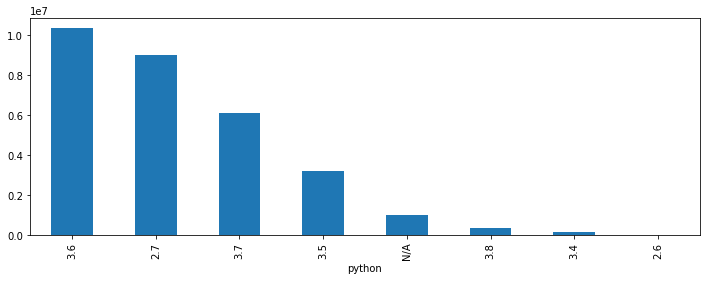

In [6]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False)[:8].plot.bar(figsize=(12, 4));

In [7]:
df.groupby('python')['downloads'].sum()\
    .sort_values(ascending=False).to_frame()\
    .apply(lambda x: x / x.sum()).style.format('{:.2%}').set_uuid('6')

,downloads
python,
3.6,34.19%
2.7,29.81%
3.7,20.22%
3.5,10.62%
N/A,3.34%
3.8,1.24%
3.4,0.54%
2.6,0.02%
3.3,0.02%


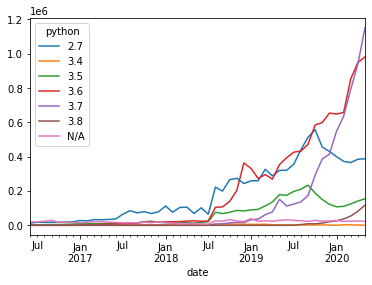

In [8]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 1000].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .plot();

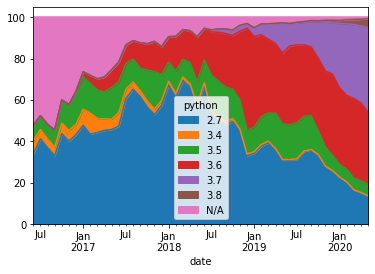

In [9]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 1000].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .stack().groupby('date').transform(lambda g: 100 * g / g.sum()).unstack()\
    .plot(kind='area');

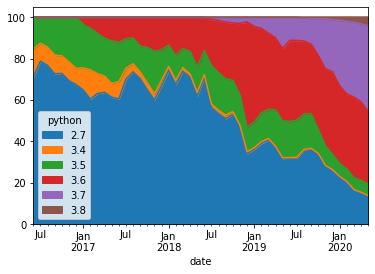

In [10]:
df.groupby(['year', 'month', 'python']).sum()\
    [lambda x: x['downloads'] > 1000].reset_index()\
    .assign(date=lambda x: pd.to_datetime(x[['year', 'month']].assign(day=1)))\
    .pivot(index='date', columns='python', values='downloads').fillna(0, downcast='infer')\
    .drop('N/A', axis=1).stack().groupby('date').transform(lambda g: 100 * g / g.sum()).unstack()\
    .plot(kind='area');

In [11]:
gf = df[df['project'] == 'graphviz'].drop('project', axis=1)
gf.tail()

,year,month,version,type,country,python,system,downloads
388810,2020,5,0.9,sdist,SE,N/A,N/A,1
388811,2020,5,0.9,sdist,SK,N/A,N/A,1
388812,2020,5,0.9,sdist,US,3.7,Linux,1
388813,2020,5,0.9,sdist,US,N/A,N/A,21
388814,2020,5,0.9,sdist,N/A,N/A,N/A,1


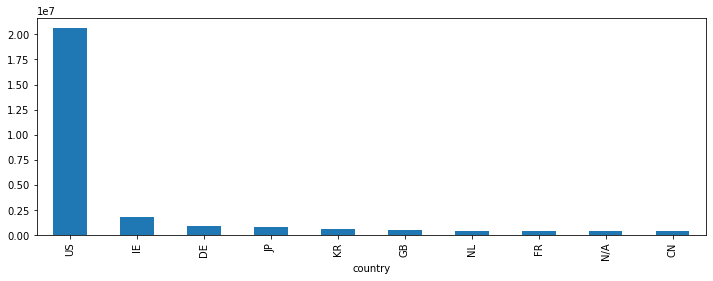

In [12]:
gf.groupby('country')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

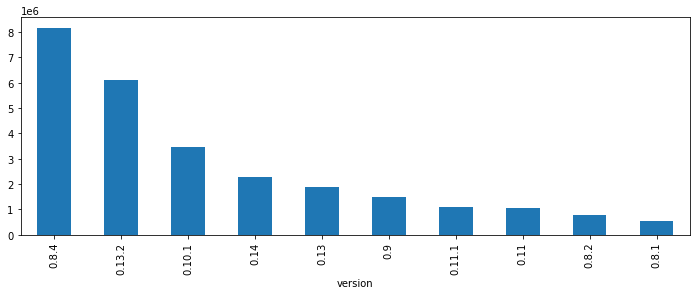

In [13]:
gf.groupby('version')['downloads'].sum().sort_values(ascending=False)[:10].plot.bar(figsize=(12, 4));

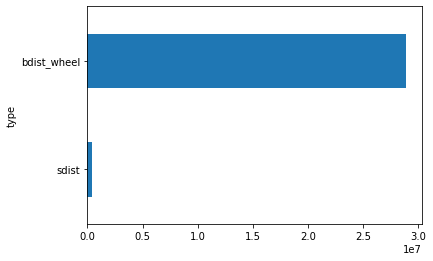

In [14]:
gf.groupby('type')['downloads'].sum().sort_values().plot.barh();

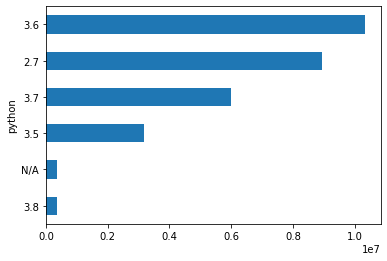

In [15]:
gf.groupby('python')['downloads'].sum().sort_values()[-6:].plot.barh();

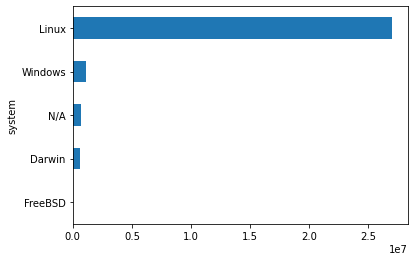

In [16]:
gf.groupby('system')['downloads'].sum().sort_values()[-5:].plot.barh();